In [1]:
# Load libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, BatchNormalization

In [2]:
# Load data from csv file
data = pd.read_csv('vn_selected.csv')
data_vn = data.copy()
data_vn.head()

,Date,Ticker,Low,Open,Volume,High,Close,AdjustedClose
0,2001-01-03,HAP,1389.0,1389.0,8300,1389.0,1389.0,NaN
1,2001-01-05,HAP,1416.0,1416.0,900,1416.0,1416.0,NaN
2,2001-01-08,HAP,1444.0,1444.0,11000,1444.0,1444.0,NaN
3,2001-01-10,HAP,1471.0,1471.0,27300,1471.0,1471.0,NaN
4,2001-01-12,HAP,1444.0,1444.0,14700,1444.0,1444.0,NaN


In [3]:
data_vn = data_vn.copy()
data_vn.drop(columns=['AdjustedClose'], inplace=True)
data_vn.head()

,Date,Ticker,Low,Open,Volume,High,Close
0,2001-01-03,HAP,1389.0,1389.0,8300,1389.0,1389.0
1,2001-01-05,HAP,1416.0,1416.0,900,1416.0,1416.0
2,2001-01-08,HAP,1444.0,1444.0,11000,1444.0,1444.0
3,2001-01-10,HAP,1471.0,1471.0,27300,1471.0,1471.0
4,2001-01-12,HAP,1444.0,1444.0,14700,1444.0,1444.0


In [4]:
# First, calculate 20-day and 50-day Simple Moving Averages on Open price

# 1. Simple Moving Average (SMA)
data_vn['SMA_20'] = data_vn['Open'].rolling(window=20).mean()  # 20-day SMA on Open price
data_vn['SMA_50'] = data_vn['Open'].rolling(window=50).mean()  # 50-day SMA on Open price

# 2. Exponential Moving Average (EMA)
data_vn['EMA_12'] = data_vn['Open'].ewm(span=12, adjust=False).mean()  # 12-day EMA on Open price
data_vn['EMA_26'] = data_vn['Open'].ewm(span=26, adjust=False).mean()  # 26-day EMA on Open price

# 3. Trading Signals based on crossovers

# Buy signal: when short-term SMA/EMA crosses above the long-term SMA/EMA
# Sell signal: when short-term SMA/EMA crosses below the long-term SMA/EMA
# Buy Signal: SMA_Signal == 1 (Golden Cross: Short-term MA crosses above long-term MA).
# Sell Signal: SMA_Signal == -1 (Death Cross: Short-term MA crosses below long-term MA).

# Initialize signals column
data_vn['SMA_Signal'] = 0

# Buy when 20-day SMA crosses above the 50-day SMA
data_vn.loc[(data_vn['SMA_20'] > data_vn['SMA_50']), 'SMA_Signal'] = 1  # Buy Signal (Bullish Crossover)
# Sell when 20-day SMA crosses below the 50-day SMA
data_vn.loc[(data_vn['SMA_20'] < data_vn['SMA_50']), 'SMA_Signal'] = -1  # Sell Signal (Bearish Crossover)

# Let's create signals based on EMA as well:
data_vn['EMA_Signal'] = 0
data_vn.loc[(data_vn['EMA_12'] > data_vn['EMA_26']), 'EMA_Signal'] = 1  # Buy Signal (Bullish EMA Crossover)
data_vn.loc[(data_vn['EMA_12'] < data_vn['EMA_26']), 'EMA_Signal'] = -1  # Sell Signal (Bearish EMA Crossover)

# To view the signals:
print(data_vn[['Open', 'SMA_20', 'SMA_50', 'SMA_Signal', 'EMA_12', 'EMA_26', 'EMA_Signal']].tail())

        Open  SMA_20  SMA_50  SMA_Signal       EMA_12       EMA_26  EMA_Signal
5394  4100.0  4407.0  4459.8          -1  4250.743360  4359.769192          -1
5395  4350.0  4390.0  4450.4          -1  4266.013613  4359.045548          -1
5396  4270.0  4363.5  4445.6          -1  4266.626903  4352.449582          -1
5397  4210.0  4339.0  4437.4          -1  4257.915072  4341.897761          -1
5398  4070.0  4302.5  4423.8          -1  4229.005061  4321.757186          -1


In [5]:
'''
# Calculate MACD on Open price
data_vn['EMA_12'] = data_vn['Open'].ewm(span=12, adjust=False).mean()  # 12-day EMA
data_vn['EMA_26'] = data_vn['Open'].ewm(span=26, adjust=False).mean()  # 26-day EMA
'''
# MACD Line
data_vn['MACD'] = data_vn['EMA_12'] - data_vn['EMA_26']

# Signal Line (9-day EMA of MACD Line)
data_vn['Signal_Line'] = data_vn['MACD'].ewm(span=9, adjust=False).mean()

# Optional: MACD Histogram
data_vn['MACD_Histogram'] = data_vn['MACD'] - data_vn['Signal_Line']

# Generate trading signals based on MACD crossover
#Buy Signal: When MACD crosses above the signal line (i.e., MACD_Signal = 1).
#Sell Signal: When MACD crosses below the signal line (i.e., MACD_Signal = -1).
data_vn['MACD_Signal'] = 0
data_vn.loc[data_vn['MACD'] > data_vn['Signal_Line'], 'MACD_Signal'] = 1  # Buy Signal (Bullish Crossover)
data_vn.loc[data_vn['MACD'] < data_vn['Signal_Line'], 'MACD_Signal'] = -1  # Sell Signal (Bearish Crossover)

# To view the results
print(data_vn[['Open', 'MACD', 'Signal_Line', 'MACD_Signal']].tail())


        Open        MACD  Signal_Line  MACD_Signal
5394  4100.0 -109.025832   -90.474946           -1
5395  4350.0  -93.031936   -90.986344           -1
5396  4270.0  -85.822679   -89.953611            1
5397  4210.0  -83.982689   -88.759426            1
5398  4070.0  -92.752125   -89.557966           -1


In [ ]:
Can use ta library to caculate

In [6]:
# Calculate daily price changes on Open price
data_vn['Price_Change'] = data_vn['Open'].diff()

# Calculate gains and losses
data_vn['Gain'] = np.where(data_vn['Price_Change'] > 0, data_vn['Price_Change'], 0)
data_vn['Loss'] = np.where(data_vn['Price_Change'] < 0, abs(data_vn['Price_Change']), 0)

# Calculate the average gain and loss over 14 periods (RSI standard period)
data_vn['Avg_Gain'] = data_vn['Gain'].rolling(window=14).mean()
data_vn['Avg_Loss'] = data_vn['Loss'].rolling(window=14).mean()
data_vn.head()



,Date,Ticker,Low,Open,Volume,High,Close,SMA_20,SMA_50,EMA_12,...,EMA_Signal,MACD,Signal_Line,MACD_Histogram,MACD_Signal,Price_Change,Gain,Loss,Avg_Gain,Avg_Loss
0,2001-01-03,HAP,1389.0,1389.0,8300,1389.0,1389.0,NaN,NaN,1389.000000,...,0,0.000000,0.000000,0.000000,0,NaN,0.0,0.0,NaN,NaN
1,2001-01-05,HAP,1416.0,1416.0,900,1416.0,1416.0,NaN,NaN,1393.153846,...,1,2.153846,0.430769,1.723077,1,27.0,27.0,0.0,NaN,NaN
2,2001-01-08,HAP,1444.0,1444.0,11000,1444.0,1444.0,NaN,NaN,1400.976331,...,1,6.050405,1.554696,4.495709,1,28.0,28.0,0.0,NaN,NaN
3,2001-01-10,HAP,1471.0,1471.0,27300,1471.0,1471.0,NaN,NaN,1411.749203,...,1,11.188161,3.481389,7.706772,1,27.0,27.0,0.0,NaN,NaN
4,2001-01-12,HAP,1444.0,1444.0,14700,1444.0,1444.0,NaN,NaN,1416.710864,...,1,12.932121,5.371536,7.560586,1,-27.0,0.0,27.0,NaN,NaN


In [8]:
# drop avaerage_gain and average_loss null values and other nan values
data_vn.dropna(inplace=True)
data_vn.head()

,Date,Ticker,Low,Open,Volume,High,Close,SMA_20,SMA_50,EMA_12,...,EMA_Signal,MACD,Signal_Line,MACD_Histogram,MACD_Signal,Price_Change,Gain,Loss,Avg_Gain,Avg_Loss
49,2001-05-07,HAP,2781.0,2781.0,400,2781.0,2781.0,2375.00,1953.10,2544.048860,...,1,227.404616,203.284133,24.120484,1,46.0,46.0,0.0,42.357143,0.0
50,2001-05-09,HAP,2826.0,2826.0,200,2826.0,2826.0,2414.50,1981.84,2587.425958,...,1,233.051659,209.237638,23.814021,1,45.0,45.0,0.0,43.428571,0.0
51,2001-05-11,HAP,2872.0,2872.0,100,2872.0,2872.0,2454.75,2010.96,2631.206580,...,1,238.489636,215.088037,23.401599,1,46.0,46.0,0.0,44.500000,0.0
52,2001-05-14,HAP,2917.0,2917.0,100,2917.0,2917.0,2495.75,2040.42,2675.174798,...,1,243.622073,220.794844,22.827228,1,45.0,45.0,0.0,45.571429,0.0
53,2001-05-16,HAP,2963.0,2963.0,2000,2963.0,2963.0,2537.55,2070.26,2719.455599,...,1,248.536408,226.343157,22.193251,1,46.0,46.0,0.0,45.571429,0.0


In [9]:
data_vn.isna().sum()

,0
Date,0
Ticker,0
Low,0
Open,0
Volume,0
High,0
Close,0
SMA_20,0
SMA_50,0
EMA_12,0


In [10]:
# Calculate Relative Strength (RS)
data_vn['RS'] = data_vn['Avg_Gain'] / data_vn['Avg_Loss']

# Calculate RSI
data_vn['RSI'] = 100 - (100 / (1 + data_vn['RS']))

# Buy Signal: RSI is below 30, indicating an oversold condition (potential reversal upward).
# Sell Signal: RSI is above 70, indicating an overbought condition (potential reversal downward).

# Generate trading signals based on RSI levels
data_vn['RSI_Signal'] = 0
data_vn.loc[data_vn['RSI'] > 70, 'RSI_Signal'] = -1  # Sell Signal (Overbought)
data_vn.loc[data_vn['RSI'] < 30, 'RSI_Signal'] = 1  # Buy Signal (Oversold)

# To view the results
print(data_vn[['Open', 'RSI', 'RSI_Signal']].tail())

        Open        RSI  RSI_Signal
5394  4100.0  27.131783           1
5395  4350.0  43.795620           0
5396  4270.0  40.140845           0
5397  4210.0  40.714286           0
5398  4070.0  41.911765           0


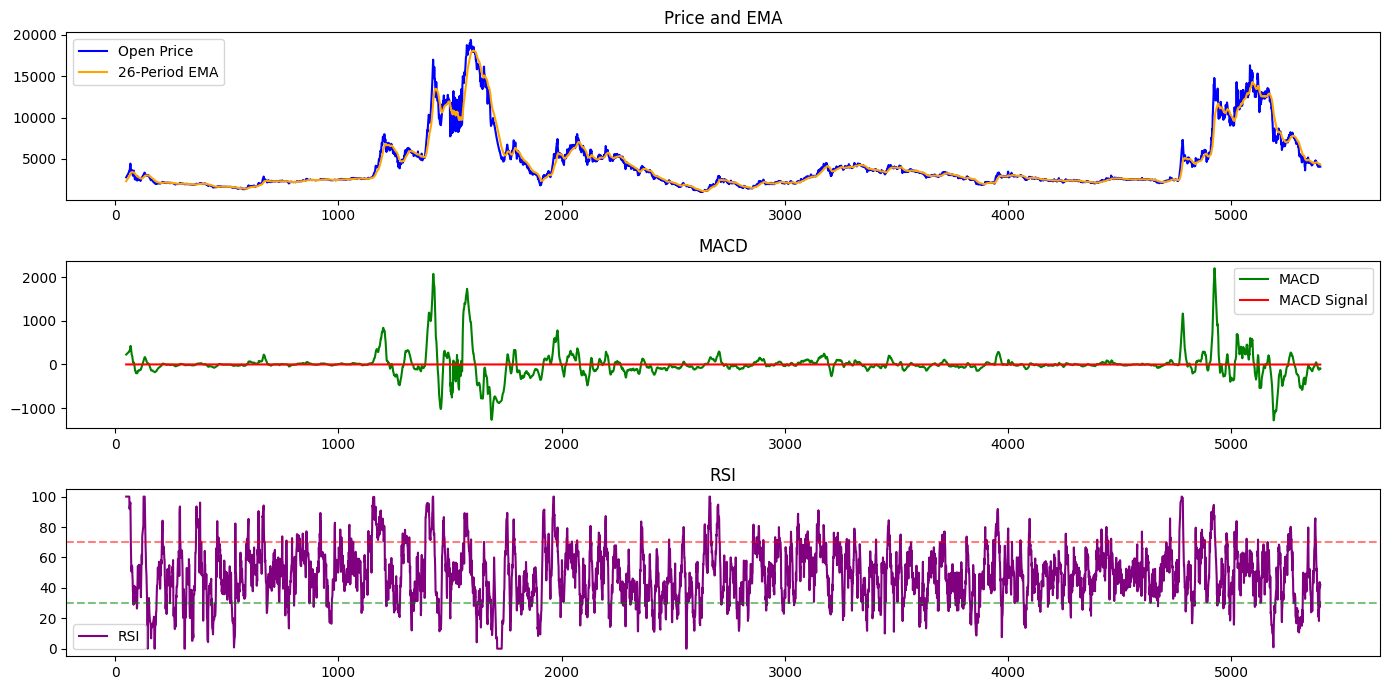

In [11]:
import matplotlib.pyplot as plt

# Plotting
plt.figure(figsize=(14, 7))

# Price and EMA
plt.subplot(3, 1, 1)
plt.plot(data_vn['Open'], label='Open Price', color='blue')
plt.plot(data_vn['EMA_26'], label='26-Period EMA', color='orange')
plt.title('Price and EMA')
plt.legend()

# MACD
plt.subplot(3, 1, 2)
plt.plot(data_vn['MACD'], label='MACD', color='green')
plt.plot(data_vn['MACD_Signal'], label='MACD Signal', color='red')
plt.title('MACD')
plt.legend()

# RSI
plt.subplot(3, 1, 3)
plt.plot(data_vn['RSI'], label='RSI', color='purple')
plt.axhline(70, linestyle='--', color='red', alpha=0.5)
plt.axhline(30, linestyle='--', color='green', alpha=0.5)
plt.title('RSI')
plt.legend()

plt.tight_layout()
plt.show()


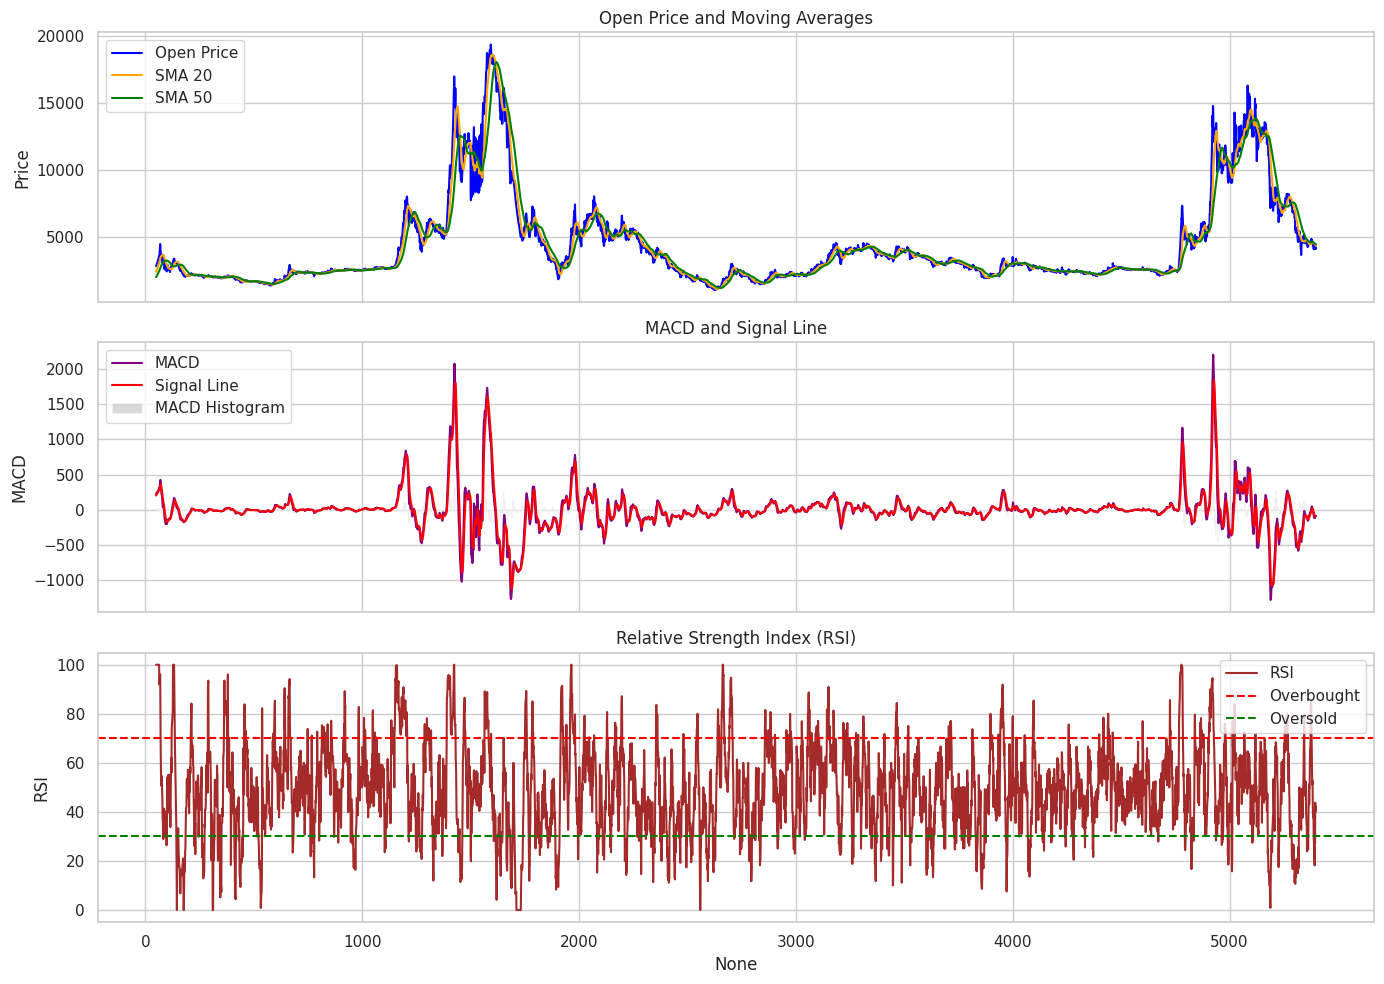

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the Seaborn style
sns.set(style="whitegrid")

# Create a figure and subplots
fig, (ax1, ax2, ax3) = plt.subplots(3, figsize=(14, 10), sharex=True)

# 1. Plot Open price and SMA/EMA on ax1
sns.lineplot(x=data_vn.index, y=data_vn['Open'], ax=ax1, label='Open Price', color='blue')
sns.lineplot(x=data_vn.index, y=data_vn['SMA_20'], ax=ax1, label='SMA 20', color='orange')
sns.lineplot(x=data_vn.index, y=data_vn['SMA_50'], ax=ax1, label='SMA 50', color='green')
ax1.set_title('Open Price and Moving Averages')
ax1.set_ylabel('Price')
ax1.legend()

# 2. Plot MACD and Signal Line on ax2
sns.lineplot(x=data_vn.index, y=data_vn['MACD'], ax=ax2, label='MACD', color='purple')
sns.lineplot(x=data_vn.index, y=data_vn['Signal_Line'], ax=ax2, label='Signal Line', color='red')
ax2.bar(data_vn.index, data_vn['MACD_Histogram'], label='MACD Histogram', color='gray', alpha=0.3)
ax2.set_title('MACD and Signal Line')
ax2.set_ylabel('MACD')
ax2.legend()

# 3. Plot RSI on ax3
sns.lineplot(x=data_vn.index, y=data_vn['RSI'], ax=ax3, label='RSI', color='brown')
ax3.axhline(70, linestyle='--', color='red', label='Overbought')
ax3.axhline(30, linestyle='--', color='green', label='Oversold')
ax3.set_title('Relative Strength Index (RSI)')
ax3.set_ylabel('RSI')
ax3.legend()

# Show the plot
plt.tight_layout()
plt.show()


In [13]:
data_vn.columns

Index(['Date', 'Ticker', 'Low', 'Open', 'Volume', 'High', 'Close', 'SMA_20',
       'SMA_50', 'EMA_12', 'EMA_26', 'SMA_Signal', 'EMA_Signal', 'MACD',
       'Signal_Line', 'MACD_Histogram', 'MACD_Signal', 'Price_Change', 'Gain',
       'Loss', 'Avg_Gain', 'Avg_Loss', 'RS', 'RSI', 'RSI_Signal'],
      dtype='object')

In [14]:
def make_decision(df):
  df['Decision'] = 0 #hold
  for i in df.index[1:]:
    if (df.loc[i, 'SMA_Signal']+df.loc[i, 'MACD_Signal']+ df.loc[i,'RSI_Signal']) >= 2:
      df.loc[i, 'Decision'] = 1 # buy
    elif (df.loc[i, 'SMA_Signal']+df.loc[i, 'MACD_Signal']+df.loc[i,'RSI_Signal']) <= -2:
      df.loc[i, 'Decision'] = -1 # sell
    else:
      df.loc[i, 'Decision'] = 0
  return df


In [ ]:
TO DO: handle infinite data

In [15]:
make_decision(data_vn)

,Date,Ticker,Low,Open,Volume,High,Close,SMA_20,SMA_50,EMA_12,...,MACD_Signal,Price_Change,Gain,Loss,Avg_Gain,Avg_Loss,RS,RSI,RSI_Signal,Decision
49,2001-05-07,HAP,2781.0,2781.0,400,2781.0,2781.0,2375.00,1953.10,2544.048860,...,1,46.0,46.0,0.0,42.357143,0.000000,inf,100.000000,-1,0
50,2001-05-09,HAP,2826.0,2826.0,200,2826.0,2826.0,2414.50,1981.84,2587.425958,...,1,45.0,45.0,0.0,43.428571,0.000000,inf,100.000000,-1,0
51,2001-05-11,HAP,2872.0,2872.0,100,2872.0,2872.0,2454.75,2010.96,2631.206580,...,1,46.0,46.0,0.0,44.500000,0.000000,inf,100.000000,-1,0
52,2001-05-14,HAP,2917.0,2917.0,100,2917.0,2917.0,2495.75,2040.42,2675.174798,...,1,45.0,45.0,0.0,45.571429,0.000000,inf,100.000000,-1,0
53,2001-05-16,HAP,2963.0,2963.0,2000,2963.0,2963.0,2537.55,2070.26,2719.455599,...,1,46.0,46.0,0.0,45.571429,0.000000,inf,100.000000,-1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5394,2023-02-22,HAP,4100.0,4100.0,198923,4380.0,4350.0,4407.00,4459.80,4250.743360,...,-1,-240.0,0.0,240.0,25.000000,67.142857,0.372340,27.131783,1,0
5395,2023-02-23,HAP,4190.0,4350.0,135195,4360.0,4280.0,4390.00,4450.40,4266.013613,...,-1,250.0,250.0,0.0,42.857143,55.000000,0.779221,43.795620,0,-1
5396,2023-02-24,HAP,4220.0,4270.0,37711,4290.0,4250.0,4363.50,4445.60,4266.626903,...,1,-80.0,0.0,80.0,40.714286,60.714286,0.670588,40.140845,0,0
5397,2023-02-27,HAP,4070.0,4210.0,109406,4210.0,4070.0,4339.00,4437.40,4257.915072,...,1,-60.0,0.0,60.0,40.714286,59.285714,0.686747,40.714286,0,0


In [16]:
import plotly.graph_objects as go
'''
# Sample data_vnFrame with date, closing price, and trading Decisions
data_vn = pd.data_vnFrame({
    'Date': pd.date_range(start='2023-01-01', periods=10),
    'Open': [100, 102, 101, 103, 105, 104, 106, 108, 107, 109],
    'High': [102, 104, 102, 106, 107, 106, 110, 112, 109, 111],
    'Low': [99, 100, 100, 102, 104, 103, 105, 107, 106, 107],
    'Close': [101, 103, 101, 105, 106, 105, 109, 111, 108, 110],
    'Decision': ['hold', 'buy', 'buy', 'hold', 'sell', 'hold', 'buy', 'hold', 'sell', 'buy']
})
'''
# Create a candlestick chart
fig = go.Figure(data=[go.Candlestick(x=data_vn['Date'],
                                       open=data_vn['Open'],
                                       high=data_vn['High'],
                                       low=data_vn['Low'],
                                       close=data_vn['Close'],
                                       name='Candlestick'),
                      go.Scatter(x=data_vn['Date'][data_vn['Decision'] == 1],
                                 y=data_vn['Close'][data_vn['Decision'] == 1],
                                 mode='markers',
                                 marker=dict(color='green', size=10),
                                 name='Buy Decision'),
                      go.Scatter(x=data_vn['Date'][data_vn['Decision'] == -1],
                                 y=data_vn['Close'][data_vn['Decision'] == -1],
                                 mode='markers',
                                 marker=dict(color='red', size=10),
                                 name='Sell Decision')])

# Update layout
fig.update_layout(title='Candlestick Chart with Trading Decisions',
                  xaxis_title='Date',
                  yaxis_title='Price',
                  xaxis_rangeslider_visible=False)

# Show the plot
fig.show()


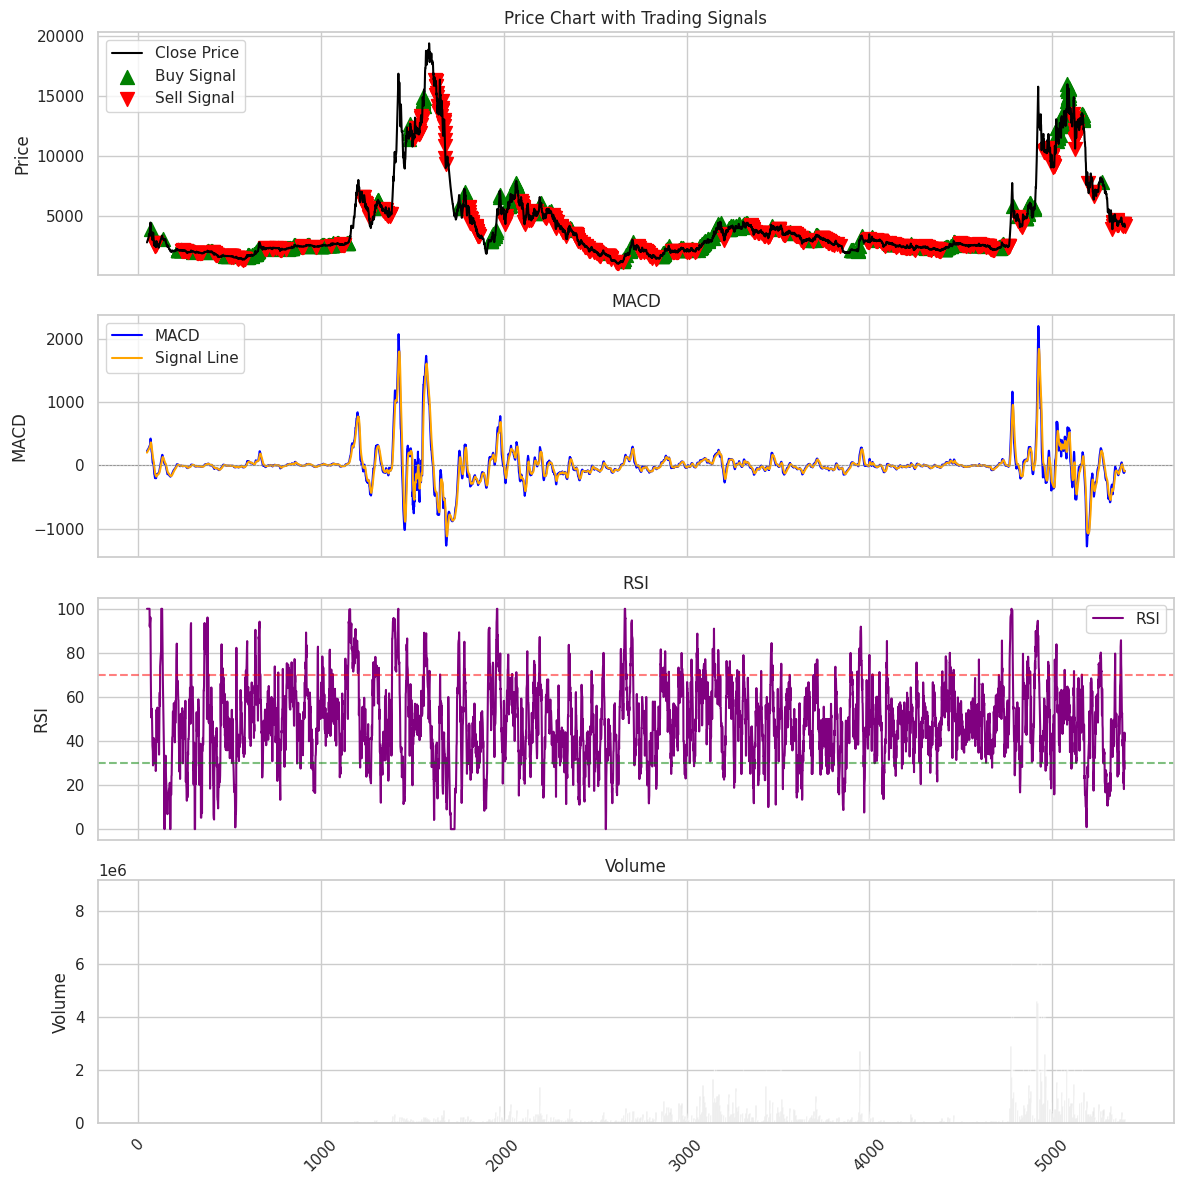

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
'''
# Sample data_vnFrame with date, open, high, low, close, and trading signals
data_vn = pd.data_vnFrame({
    'Date': pd.date_range(start='2023-01-01', periods=50),
    'Open': np.random.uniform(low=100, high=150, size=50),
    'High': np.random.uniform(low=100, high=150, size=50),
    'Low': np.random.uniform(low=100, high=150, size=50),
    'Close': np.random.uniform(low=100, high=150, size=50),
    'Volume': np.random.randint(low=1000, high=5000, size=50),
    'Signal': np.random.choice(['buy', 'sell', 'hold'], size=50)
})

data_vn['Date'] = pd.to_datetime(data_vn['Date'])
data_vn.set_index('Date', inplace=True)

# Calculate MACD and RSI
data_vn['12_EMA'] = data_vn['Close'].ewm(span=12, adjust=False).mean()
data_vn['26_EMA'] = data_vn['Close'].ewm(span=26, adjust=False).mean()
data_vn['MACD'] = data_vn['12_EMA'] - data_vn['26_EMA']
data_vn['Signal_Line'] = data_vn['MACD'].ewm(span=9, adjust=False).mean()

delta = data_vn['Close'].diff()
gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
rs = gain / loss
data_vn['RSI'] = 100 - (100 / (1 + rs))
'''
# Create buy/sell signals
data_vn['Buy_Signal'] = np.where(data_vn['Decision'] == 1, data_vn['Close'], np.nan)
data_vn['Sell_Signal'] = np.where(data_vn['Decision'] == -1, data_vn['Close'], np.nan)

# Create subplots
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(12, 12), sharex=True)

# Price Chart
ax1.plot(data_vn.index, data_vn['Close'], label='Close Price', color='black')
ax1.scatter(data_vn.index, data_vn['Buy_Signal'], marker='^', color='green', s=100, label='Buy Signal')
ax1.scatter(data_vn.index, data_vn['Sell_Signal'], marker='v', color='red', s=100, label='Sell Signal')
ax1.set_title('Price Chart with Trading Signals')
ax1.set_ylabel('Price')
ax1.legend()

# MACD Chart
ax2.plot(data_vn.index, data_vn['MACD'], label='MACD', color='blue')
ax2.plot(data_vn.index, data_vn['Signal_Line'], label='Signal Line', color='orange')
ax2.axhline(0, color='gray', linewidth=0.5, linestyle='--')
ax2.set_title('MACD')
ax2.set_ylabel('MACD')
ax2.legend()

# RSI Chart
ax3.plot(data_vn.index, data_vn['RSI'], label='RSI', color='purple')
ax3.axhline(70, color='red', linestyle='--', alpha=0.5)
ax3.axhline(30, color='green', linestyle='--', alpha=0.5)
ax3.set_title('RSI')
ax3.set_ylabel('RSI')
ax3.legend()

# Volume Chart
ax4.bar(data_vn.index, data_vn['Volume'], color='gray', alpha=0.3)
ax4.set_title('Volume')
ax4.set_ylabel('Volume')

# Format the x-axis
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [14]:
data_vn.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5350 entries, 49 to 5398
Data columns (total 28 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Date            5350 non-null   object 
 1   Ticker          5350 non-null   object 
 2   Low             5350 non-null   float64
 3   Open            5350 non-null   float64
 4   Volume          5350 non-null   int64  
 5   High            5350 non-null   float64
 6   Close           5350 non-null   float64
 7   SMA_20          5350 non-null   float64
 8   SMA_50          5350 non-null   float64
 9   EMA_12          5350 non-null   float64
 10  EMA_26          5350 non-null   float64
 11  SMA_Signal      5350 non-null   int64  
 12  EMA_Signal      5350 non-null   int64  
 13  MACD            5350 non-null   float64
 14  Signal_Line     5350 non-null   float64
 15  MACD_Histogram  5350 non-null   float64
 16  MACD_Signal     5350 non-null   int64  
 17  Price_Change    5350 non-null   float

In [16]:
data_vn.columns

Index(['Date', 'Ticker', 'Low', 'Open', 'Volume', 'High', 'Close', 'SMA_20',
       'SMA_50', 'EMA_12', 'EMA_26', 'SMA_Signal', 'EMA_Signal', 'MACD',
       'Signal_Line', 'MACD_Histogram', 'MACD_Signal', 'Price_Change', 'Gain',
       'Loss', 'Avg_Gain', 'Avg_Loss', 'RS', 'RSI', 'RSI_Signal', 'Decision',
       'Buy_Signal', 'Sell_Signal'],
      dtype='object')

In [26]:
data_vn_selected = data_vn.iloc[:, 2:26]  # Selects all rows and columns from index 2 to 24
data_vn_selected.head()

,Low,Open,Volume,High,Close,SMA_20,SMA_50,EMA_12,EMA_26,SMA_Signal,...,MACD_Signal,Price_Change,Gain,Loss,Avg_Gain,Avg_Loss,RS,RSI,RSI_Signal,Decision
49,2781.0,2781.0,400,2781.0,2781.0,2375.00,1953.10,2544.048860,2316.644243,1,...,1,46.0,46.0,0.0,42.357143,0.0,inf,100.0,-1,0
50,2826.0,2826.0,200,2826.0,2826.0,2414.50,1981.84,2587.425958,2354.374299,1,...,1,45.0,45.0,0.0,43.428571,0.0,inf,100.0,-1,0
51,2872.0,2872.0,100,2872.0,2872.0,2454.75,2010.96,2631.206580,2392.716944,1,...,1,46.0,46.0,0.0,44.500000,0.0,inf,100.0,-1,0
52,2917.0,2917.0,100,2917.0,2917.0,2495.75,2040.42,2675.174798,2431.552726,1,...,1,45.0,45.0,0.0,45.571429,0.0,inf,100.0,-1,0
53,2963.0,2963.0,2000,2963.0,2963.0,2537.55,2070.26,2719.455599,2470.919191,1,...,1,46.0,46.0,0.0,45.571429,0.0,inf,100.0,-1,0


In [ ]:
Determine training time frame before run the below code

In [18]:
### Split the dataset into time windows to get data samples.
'''Predict "Open" for the next day based on multi-feature'''

df = data_vn

X_data = []
y_data = []
window_size=30 # Time window for data feature (size of 'number of days').

# Get the low, open, volume, high, close, adjustedclose
for i in range(0, len(df) - window_size - 1):
    data_feature = []
    data_label = []

    # Get a window_size time frame for data feature
    for j in range(window_size):
        data_feature.append(df.iloc[i + j, 2:].to_numpy().tolist())

    # Next value is the label (price of the next day) to be predicted
    data_label.append(df.iloc[i + window_size, 25]) # Number 3 is the "Open" column


    # Append new data sample (feature and label) to X_data and y_data
    X_data.append(np.array(data_feature).reshape(window_size, 26))
    y_data.append(np.array(data_label))


# Time series cross-validation split


In [ ]:
normalise categorical and continuous data =)))0

In [19]:
# Step 1: Split to train and test set
from sklearn.model_selection import train_test_split
import numpy as np # Import numpy


# Split the entire dataset into train (80%) and test (20%)
X_train_full, X_test, y_train_full, y_test = train_test_split(X_data, y_data,
                                                              test_size=0.2,
                                                              random_state=42,
                                                              shuffle=False)

# Convert X_train_full and y_train_full to NumPy arrays
X_train_full = np.array(X_train_full) # Convert to NumPy array
y_train_full = np.array(y_train_full) # Convert to NumPy array
X_test = np.array(X_test) # Convert to NumPy array
y_test = np.array(y_test) # Convert to NumPy array

In [32]:
from sklearn.preprocessing import MinMaxScaler
# in this code i create 6 scaler for 6 feature, and 1 scaler for all the y data. The issue is that I should use param(scaler) by fitting x to
# transform y using that param. But now i have 6 params for x and i just need 1 param for y. so how to handle this.
# Initialize the MinMaxScaler for each feature
#y_scaler = MinMaxScaler()
y_scaler = MinMaxScaler()
# Reshape each feature (axis=-1) for scaling
X_train_norm = X_train_full.copy()
#X_val_norm = X_val.copy()
X_test_norm = X_test.copy()

# Loop through each feature (axis=2) and scale across time and samples
for i in range(X_train_full.shape[2]):
    # Flatten the data for the i-th feature and apply MinMaxScaler
    scaler = MinMaxScaler()
    X_train_norm[:, :, i] = scaler.fit_transform(X_train_full[:, :, i])
    #X_val_norm[:, :, i] = scaler.transform(X_val[:, :, i])
    X_test_norm[:, :, i] = scaler.transform(X_test[:, :, i])

    y_train_norm = y_scaler.fit_transform(y_train_full)
    #y_val_norm = y_scaler.transform(y_val)
    y_test_norm = y_scaler.transform(y_test)


# Check the new shapes (they should remain the same as before)
print("Shape of scaled training set: ", X_train_norm.shape)
#print("Shape of scaled validation set: ", X_val_norm.shape)
print("Shape of scaled test set: ", X_test_norm.shape)
print()
print("Shape of scales training label ", y_train_norm.shape)
#print("Shape of scales validation label ", y_val_norm.shape)
print("Shape of scales test label ", y_test_norm.shape)

ValueError: Input X contains infinity or a value too large for dtype('float64').

In [ ]:

def create_model():
  model_1d = tf.keras.Sequential()
  model_1d.add(Conv1D(64, kernel_size=3, activation='relu', input_shape=(window_size, 4), padding='same'))
  model_1d.add(Conv1D(64, kernel_size=3, activation='relu', padding='same'))

  model_1d.add(Conv1D(64, kernel_size=3, activation='relu', padding='same'))
  model_1d.add(Conv1D(64, kernel_size=3, activation='relu', padding='same'))
  model_1d.add(MaxPooling1D(pool_size=2))

  model_1d.add(Conv1D(128, kernel_size=3, activation='relu', padding='same'))
  model_1d.add(Conv1D(128, kernel_size=3, activation='relu', padding='same'))
  model_1d.add(Conv1D(128, kernel_size=3, activation='relu', padding='same'))
  model_1d.add(Conv1D(128, kernel_size=3, activation='relu', padding='same'))
  model_1d.add(MaxPooling1D(2))

  model_1d.add(Conv1D(128, kernel_size=3, activation='relu', padding='same'))
  model_1d.add(Conv1D(128, kernel_size=3, activation='relu', padding='same'))
  model_1d.add(Conv1D(256, kernel_size=3, activation='relu', padding='same'))
  model_1d.add(Conv1D(256, kernel_size=3, activation='relu', padding='same'))
  model_1d.add(MaxPooling1D(2))

  model_1d.add(Flatten())
  model_1d.add(Dense(100, activation='relu'))
  model_1d.add(Dense(1, activation='linear')) # By default: activation='linear', i.e., passing through f(x) = x

  model_1d.summary()
  model_1d.compile(optimizer= tf.keras.optimizers.Adam(learning_rate=0.001), loss='mean_squared_error', metrics=['mae'])
  return model_1d

In [ ]:
# Step 2: Time series split for training set
from sklearn.model_selection import TimeSeriesSplit

# Create a TimeSeriesSplit object with 5 splits
tscv = TimeSeriesSplit(n_splits=5)
loss_score = []

mc = keras.callbacks.ModelCheckpoint(filepath="/content/model_1d.keras", # Path to save the model
                                     monitor='val_loss', # Metric to evaluate the model performance when looking for a better model.
                                     mode='min', # mode='auto'/'max'/'min': the monitor should be max/min to be better.
                                                 # In auto mode, the mode is set to max if the quantities monitored are 'acc' or start with 'fmeasure' (f-score) and are set to min for the rest of the quantities.
                                     verbose=0, # Inform every time a better model is found and saved.
                                     save_best_only=True) # Only save the model if the current training epoch is the best. 'False' means save models of all training epochs

# Loop through each split generated by TimeSeriesSplit
for train_index, val_index in tscv.split(X_train_norm):
    # Use different variable names for clarity
    X_train_split, X_val = X_train_norm[train_index], X_train_norm[val_index]
    y_train_split, y_val = y_train_norm[train_index], y_train_norm[val_index]

    X_train = np.array(X_train_split)
    X_val = np.array(X_val)
    y_train = np.array(y_train_split)
    y_val = np.array(y_val)
    # Reshape the numpy array to fit the neural network input shape requirement
    window_size = 30
    X_train = X_train.reshape(X_train.shape[0], window_size, 4)
    X_val = X_val.reshape(X_val.shape[0], window_size, 4)
    X_test = X_test.reshape(X_test.shape[0], window_size, 4)
    model_1d = create_model()
    # Train the model. Using Colab for training
    history = model_1d.fit(X_train_norm, y_train_norm, # Data feature and data label
                    batch_size=512, # Batch size
                    epochs=20, # Number of training epochs
                    validation_data=(X_val, y_val), # Validation set
                    callbacks=[mc]) # Use callback ModelCheckpoint during the training
    loss= model_1d.evaluate(X_val, y_val)
    loss_score.append(loss)
    print(f"Validation loss for fold: {loss}")

print(f"Mean validation loss: {np.mean(loss_score)}")
print(f"Standard deviation of validation loss: {np.std(loss_score)}")

Epoch 11/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 10s 596ms/step - loss: 5.2814e-04 - mae: 0.0120 - val_loss: 5.3879e-05 - val_mae: 0.0054
Epoch 12/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 10s 592ms/step - loss: 5.3964e-04 - mae: 0.0117 - val_loss: 3.7288e-05 - val_mae: 0.0042
Epoch 13/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 817ms/step - loss: 4.4434e-04 - mae: 0.0105 - val_loss: 6.1584e-05 - val_mae: 0.0064
Epoch 14/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 605ms/step - loss: 4.7840e-04 - mae: 0.0118 - val_loss: 4.7311e-05 - val_mae: 0.0054
Epoch 15/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 12s 749ms/step - loss: 4.4029e-04 - mae: 0.0105 - val_loss: 5.0009e-05 - val_mae: 0.0056
Epoch 16/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 9s 707ms/step - loss: 4.2515e-04 - mae: 0.0106 - val_loss: 5.8450e-05 - val_mae: 0.0063
Epoch 17/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 6s 642ms/step - loss: 5.0563e-04 - mae: 0.0113 - val_loss: 5.2642e-05 - val_mae: 0.0060
Epoch 18/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 592ms/step - loss: 5.2936e-04 - mae: 0.0119 - val_loss: 7.9758e-05 - val_mae: 0.00

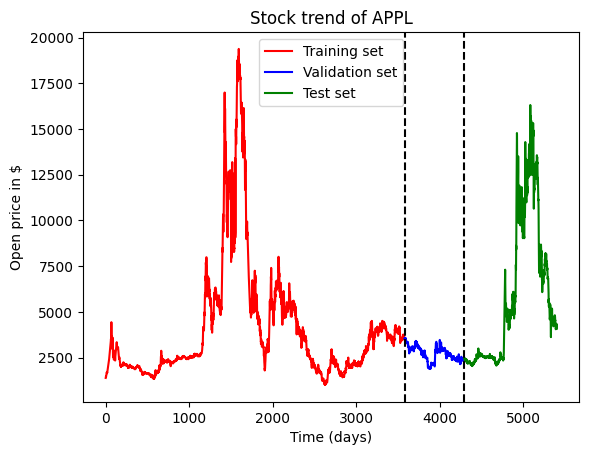

In [ ]:
# Visualize the training, validation and test set
df_plot = df['Open']
df_plot = df_plot.reset_index(drop=False)

# Get lengths of the three subsets
size_train = X_train.shape[0]
size_val = X_val.shape[0]
size_test = X_test.shape[0]

# Plot the subset splits
ax = df_plot.iloc[:size_train,1:2].plot(y=0, color='red', label='Training set')
df_plot.iloc[size_train:size_train+size_val,1:2].plot(y=0, color='blue', label='Validation set', ax=ax)
df_plot.iloc[size_train+size_val:df_plot.shape[0],1:2].plot(y=0, color='green', label='Test set', ax=ax)
ax.set_title("Stock trend of APPL")
plt.xlabel('Time (days)')
plt.ylabel('Open price in $')
plt.axvline(x=size_train, color='black', linestyle='--')
plt.axvline(x=size_train+size_val, color='black', linestyle='--')
plt.show()

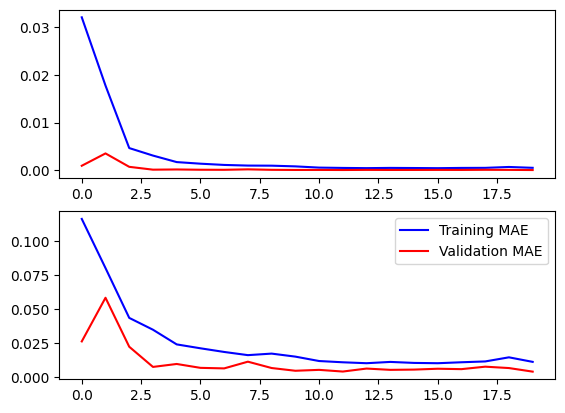

In [ ]:
# Visualize training and validation performance
f,ax=plt.subplots(2,1)

# Plot training and validation loss
ax[0].plot(history.history['loss'], color='b',label='Training Loss')
ax[0].plot(history.history['val_loss'],color='r',label='Validation Loss')

# Plot training and validation accuracy
ax[1].plot(history.history['mae'],color='b',label='Training MAE')
ax[1].plot(history.history['val_mae'],color='r',label='Validation MAE')

plt.legend()

In [ ]:
# Let us load a saved model and evaluate its performance on the test set
model_1d = tf.keras.models.load_model("/content/model_1d.keras")
result_1d = model_1d.evaluate(X_test_norm, y_test_norm) # If unspecified, batch_size will default to 32
# Show the model performance
print(model_1d.metrics_names) # result_1d[0] is loss, result_1d[1] is mse. The metrics are defined in model_1d.complie(...)
print("Loss and mae on the test set: loss = {}, mae = {}".format(result_1d[0],result_1d[1]))
# CONVO1D MODEL
### Get prediction on the test data and convert the result back to stock price (i.e., de-normalization)
from sklearn.metrics import mean_squared_error

# Get prediction on the test data
y_pred_norm = model_1d.predict(X_test_norm)


34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 3.4625e-04 - mae: 0.0091
['loss', 'compile_metrics']
Loss and mae on the test set: loss = 0.0006887138006277382, mae = 0.015307575464248657
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step


In [ ]:
print("MSE on the test set: ", mean_squared_error(y_pred_norm, y_test_norm))
# Now, to denormalize the norm data back to the original scale:
y_pred_denorm = y_scaler.inverse_transform(y_pred_norm)

# Check the shapes
print("Shape of denormalized training set: ", y_pred_denorm.shape)

MSE on the test set:  0.0006887138146768355
Shape of denormalized training set:  (1074, 1)


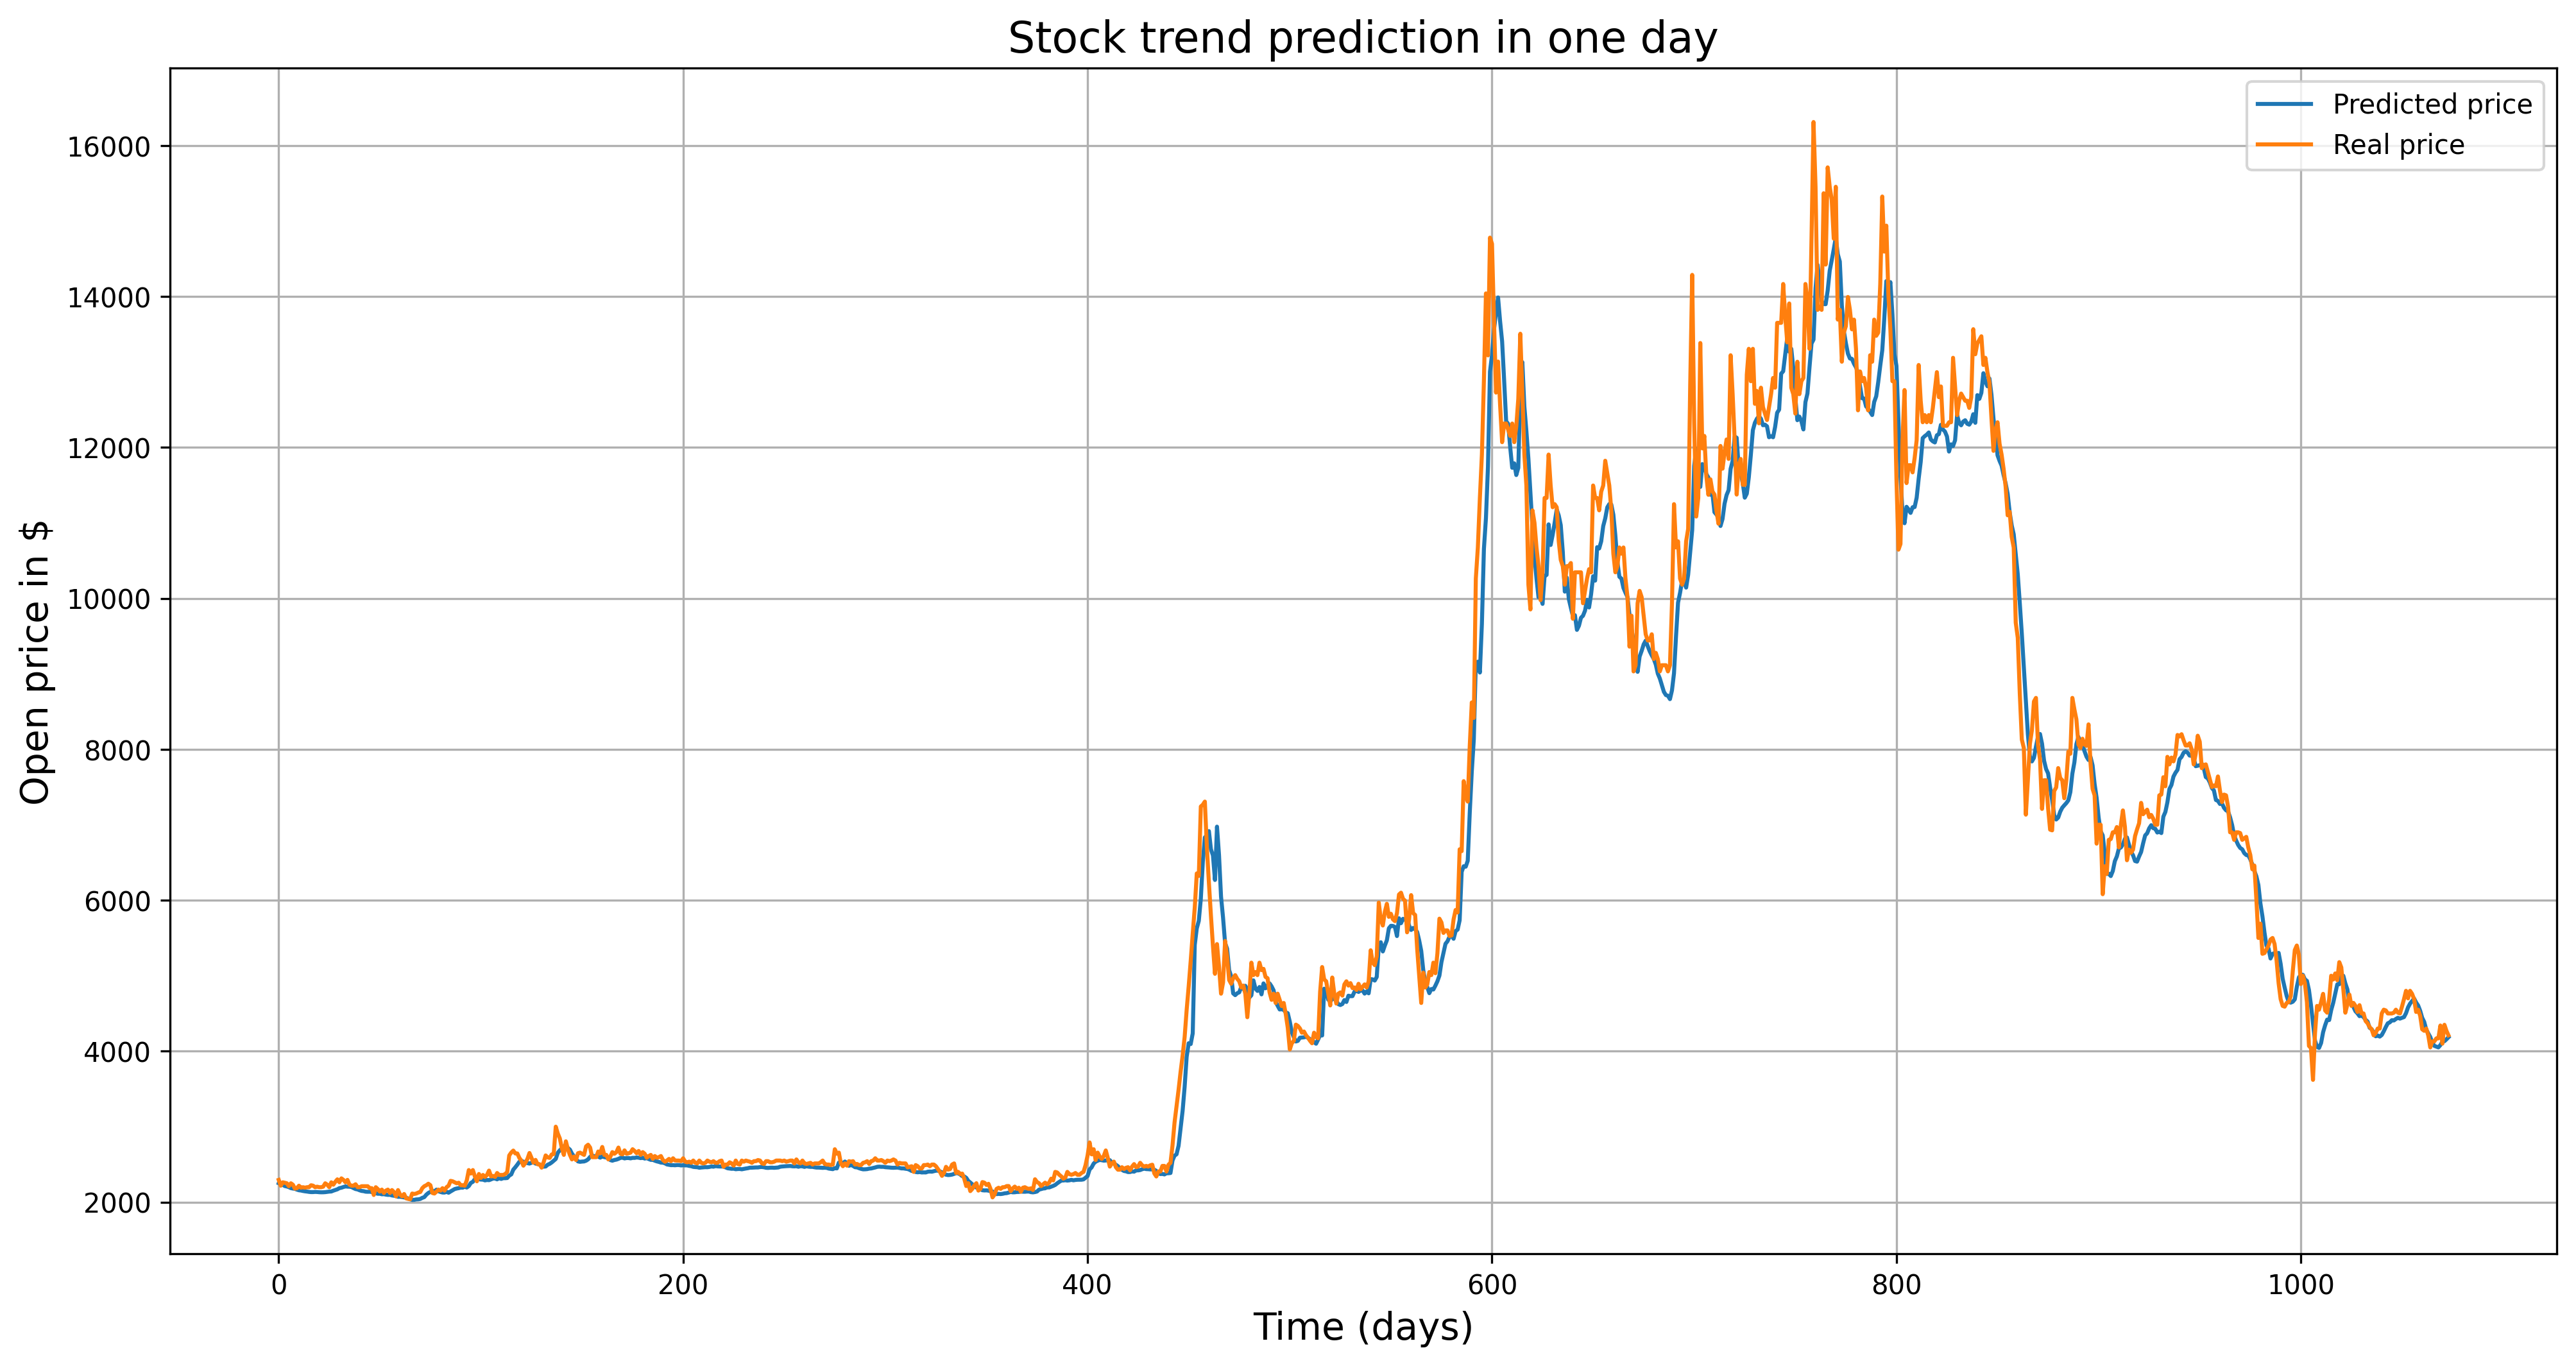

In [ ]:
# Visualize preditec stock price versus real stock price
plt.figure(figsize=(16, 8), dpi=300)
plt.plot(y_pred_denorm, label='Predicted price')
plt.plot(y_test, label='Real price')
plt.title('Stock trend prediction in one day', fontsize=16)
plt.xlabel('Time (days)', fontsize=14)
plt.ylabel('Open price in $', fontsize=14)
plt.grid() # Add grid
plt.legend() # Add legend
plt.show()

In [ ]:
time_steps = np.arange(0, 1)

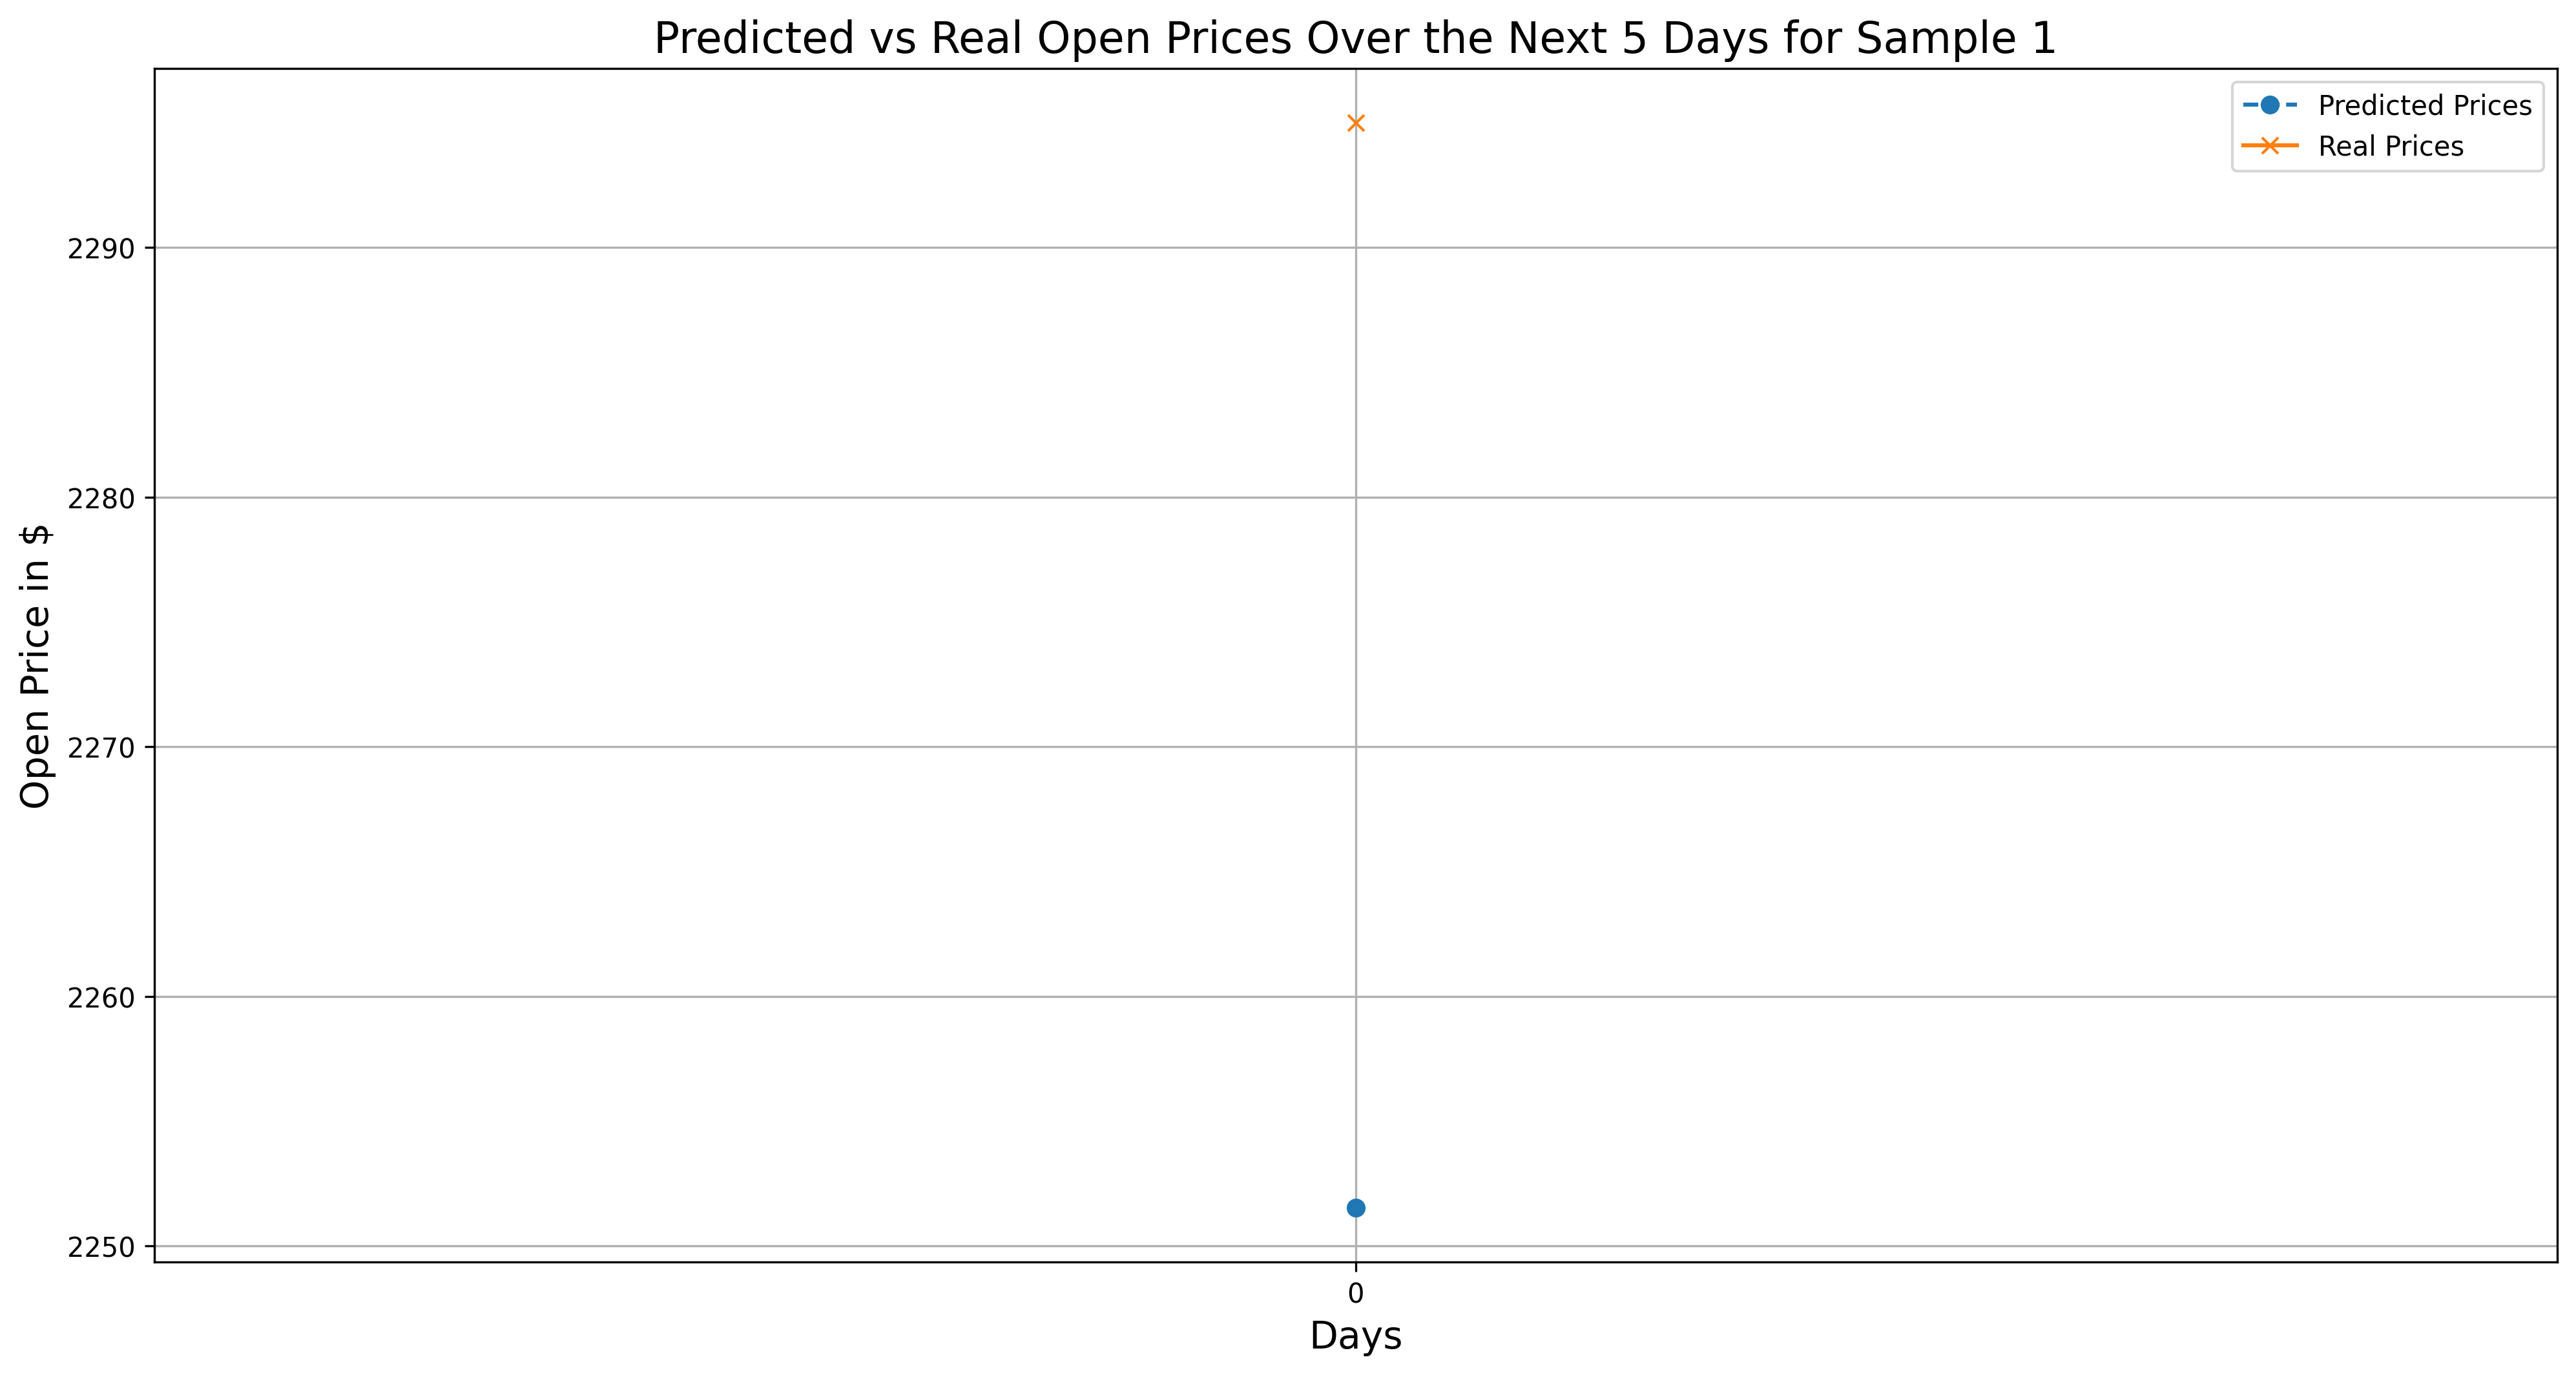

In [ ]:
plt.figure(figsize=(16, 8), dpi=300)

# Plot for the first sample only
plt.plot(time_steps, y_pred_denorm[0], label='Predicted Prices', linestyle='--', marker='o')
plt.plot(time_steps, y_test[0], label='Real Prices', linestyle='-', marker='x')

# Add titles, labels, and legend
plt.title('Predicted vs Real Open Prices Over the Next 5 Days for Sample 1', fontsize=16)
plt.xlabel('Days', fontsize=14)
plt.ylabel('Open Price in $', fontsize=14)
plt.xticks(time_steps)  # Set x-ticks to represent days
plt.grid()  # Add grid
plt.legend()  # Add legend
plt.show()
